# Final Project: EMG Extraction for Fatigue Detection
Author : Ramadhani Putri Alifa

---



## Import Libs and Dataset

In [ ]:
# import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler,  OneHotEncoder,  MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

In [ ]:
# Read the input data
# df = pd.read_csv("data.csv")
from google.colab import drive
drive.mount('/content/drive')

#Call Dataset
train = pd.read_excel('/content/drive/MyDrive/luluz/DataTA.xlsx')
df = pd.read_excel('/content/drive/MyDrive/luluz/DataTA.xlsx')
data = df.drop(df.columns[[0, 1, 2, 9, 10, 11, 12, 13, 14, 15]], axis=1)
train = train.drop(df.columns[[0, 1, 2, 9, 10, 11]], axis=1)
# data.descr

# print(f"Number of data: {data.shape[0]}")

# # #Exploratory Describe
# !pip install pandas-profiling
# from pandas_profiling import ProfileReport

# #EDA using pandas-profiling
# profile = ProfileReport(data, explorative=True)

# #Saving results to a HTML file
# profile.to_file("output.html")

print(data)
data.isnull().sum()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         MPF    RMS    VAR    ENERGY  %HRR  LVL
0    212.829  0.362  0.131  1049.008  0.36    0
1    222.111  0.390  0.152  1216.361  0.36    0
2    226.540  0.410  0.168  1343.906  0.36    0
3    228.669  0.364  0.133  1060.203  0.36    0
4    222.096  0.375  0.141  1124.835  0.36    0
..       ...    ...    ...       ...   ...  ...
103  223.235  0.315  0.099   793.959  1.00    2
104  216.606  0.371  0.138  1101.928  1.00    2
105  202.867  0.383  0.147  1175.231  1.00    2
106  202.463  0.394  0.155  1241.797  1.00    2
107  214.114  0.359  0.129  1030.078  1.00    2

[108 rows x 6 columns]


MPF       0
RMS       0
VAR       0
ENERGY    0
%HRR      0
LVL       0
dtype: int64

In [ ]:
data['LVL'].unique()

(4,)

%HRR      0.882691
RMS       0.474132
ENERGY    0.467654
VAR       0.467043
MPF       0.434188
Name: LVL, dtype: float64

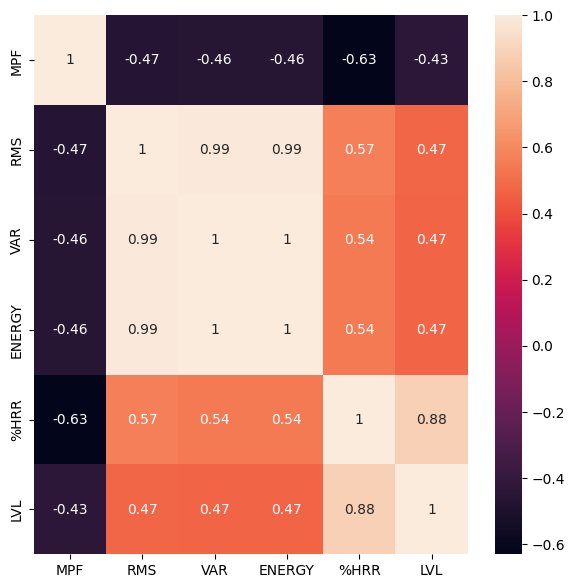

In [ ]:
corr_data = data.corr()
corr_data

plt.figure(figsize = (7,7))
sns.heatmap(corr_data, annot=True)

strong_relation_features = pd.Series(abs(corr_data['LVL'])).nlargest(n=12).iloc[1:]
strong_relation_features

%HRR         0.882691
HR DURING    0.863844
RMS          0.474132
ENERGY       0.467654
VAR          0.467043
MPF          0.434188
OR           0.101130
AGE          0.088697
HR REST      0.029174
Name: LVL, dtype: float64

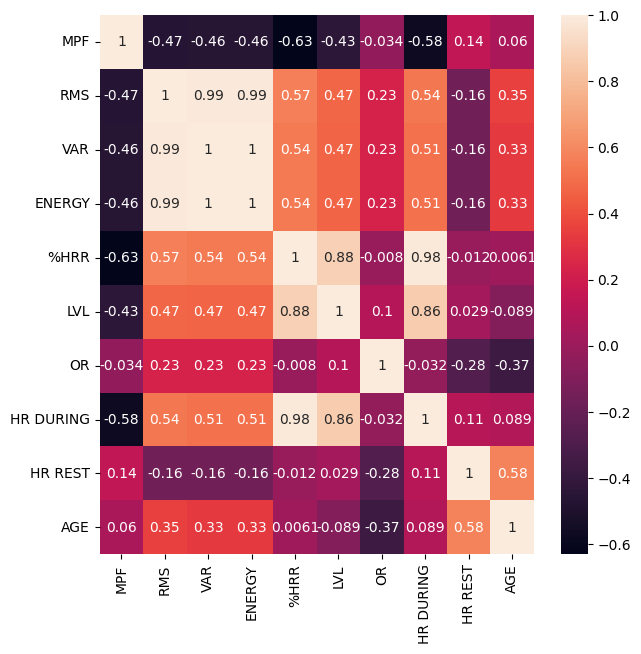

In [ ]:
corr_data = train.corr()
corr_data

plt.figure(figsize = (7,7))
sns.heatmap(corr_data, annot=True)

strong_relation_features = pd.Series(abs(corr_data['LVL'])).nlargest(n=12).iloc[1:]
strong_relation_features

In [ ]:
# Initialize the encoder
# encoder = OneHotEncoder()
# Fit and transform the data
# encoded_data = encoder.fit_transform(data[['LVL', 'FATIGUE']]).toarray()

Y= np.array(data['LVL'])  # Wrap the column names in double brackets
y_one_hot = []
for i in range(len(Y)):
  if Y[i] == 0:
    y_one_hot.append([1, 0, 0, 0])
  if Y[i] == 1:
    y_one_hot.append([0, 1, 0, 0])
  if Y[i] == 2:
    y_one_hot.append([0, 0, 1, 0])
  if Y[i] == 3:
    y_one_hot.append([0, 0, 0, 1])

# Create a DataFrame with the encoded Y and feature names
y = pd.DataFrame(y_one_hot)
y

,0,1,2,3
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
103,0,0,1,0
104,0,0,1,0
105,0,0,1,0
106,0,0,1,0


In [ ]:
# # Concatenate the encoded DataFrame with the original data
data_encoded = pd.concat([data.drop(['LVL'], axis=1), y], axis=1)

# Get the minimum and maximum values
print("MPF max/min =", np.max(data['MPF']), "/",np.min(data['MPF']) )
print("RMS max =", np.max(data['RMS']), "/",np.min(data['RMS']))
print("VAR max =", np.max(data['VAR']), "/",np.min(data['VAR']))
print("ENERGY max =", np.max(data['ENERGY']), "/",np.min(data['ENERGY']))

# # Display the encoded and scaled data
data_encoded.head()

MPF max/min = 250.896 / 178.038
RMS max = 0.517 / 0.213
VAR max = 0.267 / 0.045
ENERGY max = 2135.651 / 362.683


,MPF,RMS,VAR,ENERGY,%HRR,0,1,2,3
0,212.829,0.362,0.131,1049.008,0.36,1,0,0,0
1,222.111,0.390,0.152,1216.361,0.36,1,0,0,0
2,226.540,0.410,0.168,1343.906,0.36,1,0,0,0
3,228.669,0.364,0.133,1060.203,0.36,1,0,0,0
4,222.096,0.375,0.141,1124.835,0.36,1,0,0,0


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scale_columns = ['MPF', 'RMS', 'VAR', 'ENERGY', '%HRR']
data[scale_columns]= scaler.fit_transform(data[scale_columns])
x = data[scale_columns]
x

,MPF,RMS,VAR,ENERGY,%HRR
0,0.477518,0.490132,0.387387,0.387105,0.296703
1,0.604916,0.582237,0.481982,0.481497,0.296703
2,0.665706,0.648026,0.554054,0.553435,0.296703
3,0.694927,0.496711,0.396396,0.393419,0.296703
4,0.604711,0.532895,0.432432,0.429874,0.296703
...,...,...,...,...,...
103,0.620344,0.335526,0.243243,0.243251,1.000000
104,0.529358,0.519737,0.418919,0.416953,1.000000
105,0.340786,0.559211,0.459459,0.458298,1.000000
106,0.335241,0.595395,0.495495,0.495843,1.000000


## MLP Single Layered

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Splitting into data training and data testing
x_training, x_testing, y_training, y_testing = train_test_split(x, y, test_size = 0.2, random_state =42, shuffle=True)

In [ ]:
#ANN Setting
def get_model():
  df = tf.keras.Sequential([
      tf.keras.layers.InputLayer(5),
      tf.keras.layers.Dense(64, activation='relu',name="Hidden_1"),
      # tf.keras.layers.Dropout(0.01),
      tf.keras.layers.Dense(16, activation='relu',name="Hidden_2"),
      tf.keras.layers.Dense(8, activation='relu',name="Hidden_3"),
      tf.keras.layers.Dense(4, activation='softmax',name="Output")],
      name="Sequential")

  df.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss="categorical_crossentropy",
              metrics=['accuracy'])
  return df

#Checkpoint to save the best accuracy
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# x_train = data.drop(['LVL'], axis = 1)
# y_train = data[['LVL']]

In [ ]:
# from sklearn.model_selection import StratifiedKFold

# num_folds = 5  # Jumlah lipatan
# accuracies = []  # List untuk menyimpan skor akurasi
# lossies = []

# kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 101)
# for train_indices, val_indices in kfold.split(x_train, y_train):
#     x_training = x.iloc[train_indices]
#     y_training = np.array(y_one_hot)[train_indices]
#     x_testing = x.iloc[val_indices]
#     y_testing = np.array(y_one_hot)[val_indices]

#     # Proses pelatihan model
#     model = get_model()
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     history = model.fit(x_training, y_training, epochs=100, batch_size=2, callbacks=model_checkpoint_callback)

#     # Evaluasi model pada data validasi
#     loss, accuracy = model.evaluate(x_testing, y_testing)
#     accuracies.append(accuracy)
#     lossies.append(loss)

# Create and train the ANN classifier
model = get_model()
model.fit(x_training,y_training, epochs=300, batch_size=2 ,callbacks=model_checkpoint_callback)
model.summary()

Epoch 1/300
43/43 [==============================] - 1s 4ms/step - loss: 1.3246 - accuracy: 0.5465
Epoch 2/300
43/43 [==============================] - 0s 2ms/step - loss: 1.2151 - accuracy: 0.5465
Epoch 3/300
43/43 [==============================] - 0s 2ms/step - loss: 1.0757 - accuracy: 0.5581
Epoch 4/300
43/43 [==============================] - 0s 2ms/step - loss: 0.9225 - accuracy: 0.6047
Epoch 5/300
43/43 [==============================] - 0s 2ms/step - loss: 0.7947 - accuracy: 0.6163
Epoch 6/300
43/43 [==============================] - 0s 2ms/step - loss: 0.7079 - accuracy: 0.6395
Epoch 7/300
43/43 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.7093
Epoch 8/300
43/43 [==============================] - 0s 3ms/step - loss: 0.6020 - accuracy: 0.7209
Epoch 9/300
43/43 [==============================] - 0s 3ms/step - loss: 0.5577 - accuracy: 0.8140
Epoch 10/300
43/43 [==============================] - 0s 3ms/step - loss: 0.5329 - accuracy: 0.8140
Epoch 11/

In [ ]:
model.load_weights(checkpoint_filepath) #To load the checkpoint
print(model.layers[0].weights) #Print Weight and Bias in Hidden Layer 1
print(model.layers[1].weights) #Print Weight and Bias in Hidden Layer 2
print(model.layers[2].weights) #Print Weight and Bias in Hidden Layer 3
print(model.layers[3].weights) #Print Weight and Bias in Output Layer

[<tf.Variable 'Hidden_1/kernel:0' shape=(5, 64) dtype=float32, numpy=
array([[-0.8134798 ,  0.21557842, -0.5032461 , -0.24944942, -0.2761915 ,
         0.51766497,  0.5527919 , -0.17309761, -0.2365062 , -0.10505992,
        -0.2928735 , -0.23111057,  0.6104085 , -0.168273  , -0.2389433 ,
        -0.01757606,  0.6601088 , -0.05055507,  0.4199415 , -0.32761315,
        -0.14521003, -0.2501351 , -0.06902672, -0.22996542,  0.60085326,
        -0.14759704, -0.20269804, -0.29110318,  0.14113624, -0.24258356,
         0.1605733 ,  0.78261536, -0.11918765, -0.24382481, -0.29083654,
         0.29207474, -0.17723885,  0.42651883, -0.18936777,  0.03577632,
         0.44924006, -0.02989677, -0.25733313,  0.27906892,  0.6660021 ,
         0.13883448,  0.32763743, -0.11830238, -0.02462965, -0.15717065,
         0.4397981 ,  0.3443809 ,  0.05565318, -0.29399264,  0.48142478,
        -0.73925465,  0.39718607, -0.76283234,  0.1827    , -0.24189597,
        -0.34956205,  0.31740695, -0.2108796 ,  0.4761

In [ ]:
test_loss, test_acc = model.evaluate(x_testing,  y_testing, verbose=1)
print(f'Test accuracy: {test_acc * 100} %')
print(f'Test loss: {test_loss * 100} %')

1/1 [==============================] - 0s 194ms/step - loss: 0.1728 - accuracy: 0.9545
Test accuracy: 95.45454382896423 %
Test loss: 17.28362739086151 %


In [ ]:
#predicting using data test
prediction = model.predict(x_testing)

1/1 [==============================] - 0s 99ms/step


In [ ]:
y_baru = pd.DataFrame(y_testing)
y_baru.shape

(22, 4)

In [ ]:
prediction.shape

(22, 4)

In [ ]:
y_pred = np.argmax(prediction,axis=-1)

In [ ]:
y_pred

array([0, 3, 0, 2, 0, 3, 2, 2, 1, 3, 2, 2, 0, 2, 2, 3, 2, 0, 2, 2, 0, 0])

In [ ]:
np_y_test = y_testing.to_numpy()

In [ ]:
argmax_y_test = np.argmax(np_y_test,axis=-1)

In [ ]:
argmax_y_test

array([0, 3, 0, 2, 0, 3, 2, 2, 1, 3, 2, 2, 0, 2, 2, 3, 1, 0, 2, 2, 0, 0])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.50      0.67         2
           2       0.90      1.00      0.95         9
           3       1.00      1.00      1.00         4

    accuracy                           0.95        22
   macro avg       0.97      0.88      0.90        22
weighted avg       0.96      0.95      0.95        22



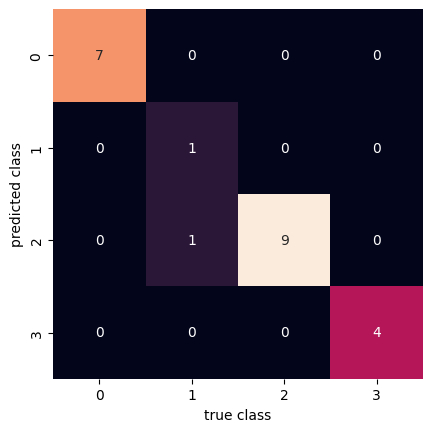

In [ ]:
conmat=confusion_matrix(argmax_y_test, y_pred)
sns.heatmap(conmat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true class')
plt.ylabel('predicted class')
print(classification_report(argmax_y_test, y_pred))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Assuming you have argmax_y_test and y_pred as numpy arrays or lists

# Calculate accuracy
accuracy = accuracy_score(argmax_y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(argmax_y_test, y_pred, average='macro')  # Use 'macro' for multiclass classification
print("Precision:", precision)

# Calculate sensitivity/recall
sensitivity = recall_score(argmax_y_test, y_pred, average='macro')  # Use 'macro' for multiclass classification
print("Sensitivity/Recall:", sensitivity)

# Calculate specificity for each class
conf_matrix = confusion_matrix(argmax_y_test, y_pred)
num_classes = conf_matrix.shape[0]
specificities = []

for i in range(num_classes):
    tn = np.sum(np.delete(conf_matrix, i, axis=0)[:, np.delete(np.arange(num_classes), i)])
    fp = np.sum(conf_matrix[np.delete(np.arange(num_classes), i), i])
    specificity = tn / (tn + fp)
    specificities.append(specificity)

print("Specificity:", specificities)


Accuracy: 0.9545454545454546
Precision: 0.975
Sensitivity/Recall: 0.875
Specificity: [1.0, 1.0, 0.9230769230769231, 1.0]
